# Wrap Complexes using Gudhi <a id="top"/>
 - [2D Wrap complex](#wrap2d)
 - [3D Wrap complex](#wrap3d)

## <a id="wrap2d" href="#top">👆</a>Wrap complex in 2D
The Wrap complex 

- is a subcomplex of the Delaunay-complex.
- can have concavities, unline the Delaunay complex, which is always convex.
- is defined in terms of critical simplices of the Delaunay function.

Consider the following sample from a cogwheel with some hollows on its surface:

In [2]:
r =   1 # amplitude of the cogwheel
R =   4 # average radius
f =   5 # number of teeth
N =  40 # Number of samples

from math import *
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

points = np.array([
    (R+r*cos(f*t))*np.array([cos(t), sin(t)])
    for t in 2*pi*rand(N)
])
fig = plt.figure()
ax  = fig.gca()
ax.set_aspect('equal')
ax.scatter(points [:,0],points [:,1])
plt.show()


Using Gudhi, we compute the $\alpha$-complex and maintain a list of the simplices and their radii.

In [3]:
import operator as op
import gudhi as gd

alpha_complex = gd.AlphaComplex(points=points)
st_alpha      = alpha_complex.create_simplex_tree()

simplex_radii = [
    (tuple(simplex), radius)
    for simplex, radius in st_alpha.get_filtration()
    if len(simplex) > 1
]

simplices = map(op.itemgetter(0), simplex_radii)
radii = {
    simplex: radius for simplex, radius in simplex_radii
}

We can visualise how the $\alpha$-complex build up when the filtration value is increased:

interactive(children=(FloatSlider(value=4.0, description='thres', max=10.0, min=0.22381336652274475, step=0.05…

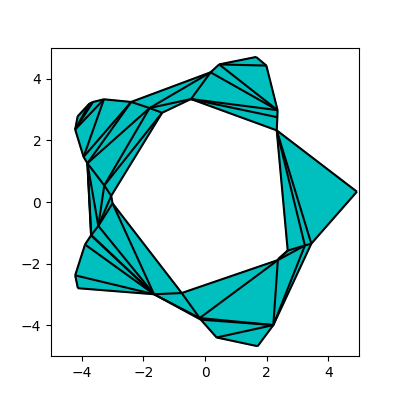

In [9]:
import itertools as it
from ipywidgets import interact
from matplotlib.collections import LineCollection

r_min = next(r for (s, r) in simplex_radii if len(s)==3)
fig = plt.figure(figsize=(4, 4))
ax  = fig.gca()   
ax.set_aspect('equal')


def delaunay2d(thres=4):
    filtration = np.array([
        simplex for simplex, radius in simplex_radii
        if radius <= thres
        and len(simplex) == 3
    ])
    edges = np.array([
        simplex for simplex, radius in simplex_radii
        if radius <= thres
        and len(simplex) == 2
    ])    
    
    ax.cla()
    ax.set_xlim(-R-r,R+r)
    ax.set_ylim(-R-r,R+r)
    ax.fill(*points[filtration].T, color='c')
    ax.add_collection(LineCollection(points[edges], color='k'))
    fig.canvas.draw()

interact(delaunay2d, thres=(r_min, 10, 0.05), continuous_update=False);


#### Acute triangles
**Definition:** A triangle is called *acute* if it has only acute angles; i.e., no angle is larger than $\frac\pi2$. 

We compute acuteness of triangles…

In [10]:
import numpy.linalg as la
def angle(v1, v2):
    cos = np.dot(v1, v2)
    sin = la.norm(np.cross(v1, v2))
    return np.arctan2(sin, cos)

def is_acute(t):
    return  len(t)==3 \
        and angle(points[t[1]]-points[t[0]], points[t[2]]-points[t[0]]) <= pi/2 \
        and angle(points[t[0]]-points[t[1]], points[t[2]]-points[t[1]]) <= pi/2 \
        and angle(points[t[0]]-points[t[2]], points[t[1]]-points[t[2]]) <= pi/2

…and include this data in our plot:

interactive(children=(FloatSlider(value=5.0, description='thres', max=15.0, min=0.22381336652274475, step=0.5)…

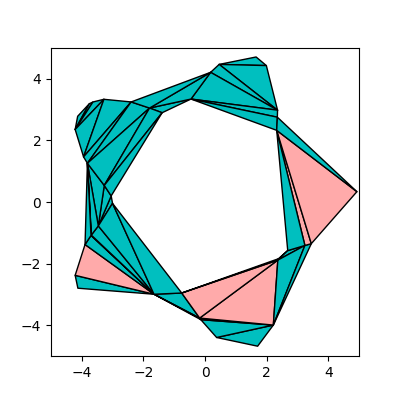

In [11]:
from matplotlib.tri import Triangulation
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(['c', 'g', '#FFAAAA'])

fig = plt.figure(figsize=(4, 4))
ax  = fig.gca()   
ax.set_aspect('equal')
def delaunay2d(thres=5):
    filtration = [
        simplex
        for simplex, radius in simplex_radii
        if len(simplex) == 3 and radius <= thres
    ]
    colors = [2*int(is_acute(triangle)) for triangle in filtration]
    ax.cla()
    ax.tripcolor(*points.T, filtration, colors, vmin=0, vmax=1, cmap=cmap, edgecolors='k', linewidth=1.0)
    ax.set_xlim(-R-r,R+r)
    ax.set_ylim(-R-r,R+r)
    fig.canvas.draw()
interact(delaunay2d, thres=(r_min, 15, 0.5));

### Critical simplices
$\newcommand\Del{\operatorname{Del}}$**Definition:** The Delaunay function $s_{\Del}$ assigns to a simplex $\sigma$ the squared radius of its smallest circumsphere that excludes all points from $X$.

We define a partition $\Del=\coprod_{I\in V}I$ such that any two simplices $\sigma\subseteq\tau$ belong to the same $I$ iff $s_{\Del}(\sigma)=s_{\Del}(\tau)$.

 - $V$ is called the discrete gradient of $s_{\Del}$
 - all $I\in V$ are *intervals* in the face poset of $\Del$
 
In The 2D case, the intervals from $V$ are either (edge, triangle)-pairs or singletons. 

**Definition:** A simplex $\sigma$ is called *critical* if it belongs to a singleton set from $V$; i. e., if $s_{\Del}$ attains the value $s_{\Del}(\sigma)$ on no face or coface of $\sigma$.  

**Fact:** 
 - The critial triangles are precisely the acute ones.
 - All vertices are critical.

In [12]:
paired_cofaces = {
    face : coface
    for coface, radius in simplex_radii
    for face in it.combinations(coface, len(coface)-1)
    if len(coface) == 3 and radius == radii[face]
}

triangles          = {s for s, _ in simplex_radii if len(s) == 3}
edges              = {s for s, _ in simplex_radii if len(s) == 2}
critical_triangles = set(filter(lambda s: s not in paired_cofaces.values(), triangles))
critical_edges     = set(filter(lambda s: s not in paired_cofaces.keys(), edges))
acute_triangles    = set(filter(is_acute, triangles))

assert(critical_triangles == acute_triangles)

### A partial order on $V$
$\newcommand\downset{\mathop{\downarrow}}$The transitive closure of the relation $I \leq J\ \text{if}\ \exists \sigma\in I, \tau\in J\colon\sigma\subseteq\tau$ defines a partial order on $V$.

For each critical simplex $\tau$ we compute the downset $\downset(\tau)=\bigcup_{I\leq\{\tau\}}I$ w. r. t. this partial order. To be slightly more efficient later, we store the down sets in a dictionary `downsets` = {$I\mapsto \downset I$}.

In [13]:
downsets = dict()
def downset(simplex):
    if downsets.get(simplex) is None:
        downsets[simplex] = {simplex}.union(*[
            downset(paired_cofaces.get(face))
            for face in it.combinations(simplex, len(simplex)-1)
            if  paired_cofaces.get(face) is not None 
            and paired_cofaces.get(face) != simplex
        ])
    return downsets[simplex]

Let's have a look into the down sets of the critical triangles:

In [14]:
for triangle in critical_triangles:
    print("↓%-15s = %s" % (triangle, downset(triangle)))

↓(3, 17, 39)     = {(3, 17, 39)}
↓(9, 21, 22)     = {(9, 21, 22)}
↓(6, 21, 22)     = {(6, 21, 22)}
↓(3, 17, 19)     = {(11, 19, 34), (3, 19, 25), (3, 17, 19), (19, 25, 34)}
↓(13, 16, 18)    = {(12, 16, 39), (18, 22, 32), (14, 23, 33), (22, 35, 37), (7, 29, 30), (6, 22, 32), (13, 24, 36), (20, 23, 33), (12, 27, 28), (13, 16, 18), (2, 29, 30), (10, 13, 24), (13, 22, 35), (13, 16, 36), (1, 29, 31), (0, 2, 30), (0, 2, 4), (5, 12, 28), (0, 4, 10), (4, 10, 24), (14, 23, 35), (16, 18, 39), (13, 18, 22), (1, 7, 29), (5, 12, 26), (20, 33, 38), (12, 16, 27), (17, 18, 39), (23, 35, 37)}
↓(8, 12, 26)     = {(8, 12, 26), (8, 12, 15)}


Indeed, not all triangles are in the downsets of critical ones:

In [15]:
print(
    "Triangles below critical ones:       ",
    len(set.union(*map(downset, critical_triangles))),
    "\nTriangles not below any critical one:",
    len(set(triangles) - set.union(*map(downset, critical_triangles)))
)

Triangles below critical ones:        38 
Triangles not below any critical one: 27


#### The Wrap Complex
**Definition:** The Wrap complex is the union $\operatorname{Wrap}_r(x)=\bigcup_{\tau\ \text{critical}}\ \downset(\tau)$.

We see that the Wrap complex recovers the shape of our sample:

interactive(children=(FloatSlider(value=5.0, description='thres', max=10.0, min=0.22381336652274475, step=0.05…

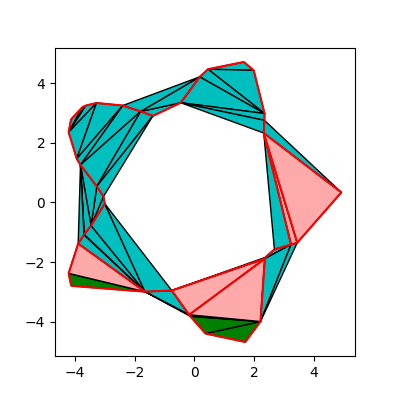

In [16]:
fig = plt.figure(figsize=(4, 4))
ax  = fig.gca()   
ax.set_aspect('equal')
ax.set_xlim(-R-r,R+r)
ax.set_ylim(-R-r,R+r)

def delaunay2d(thres=5):
    Del_r_2 = [
            triangle
            for triangle, radius in simplex_radii
            if len(triangle)==3 and radius <= thres
        ]
    Crit_r_2 = set(Del_r_2)  & critical_triangles
    Wrap_r_2 = set.union(*map(downset, Crit_r_2))
    Crit_r_1 = [
        edge
        for edge, radius in simplex_radii
        if len(edge)==2 and radius <= thres
        and edge in critical_edges
    ]
    
    ax.cla()
    ax.tripcolor(
        *points.T,
        Del_r_2, 
        [
            2 if t in Crit_r_2 else 1 if t in Wrap_r_2 else 0
            for t in Del_r_2
        ], 
        vmin=0, vmax=2, cmap=cmap, linewidth=1.0, edgecolor='k'
    )
    ax.add_collection(LineCollection(
        points[list(Crit_r_1)], color = 'r')
    )

interact(delaunay2d, thres=(r_min, 10, 0.05));

### Discrete vector field of $s_{\Del}$
Recall the discrete vector field $V$ of $s_{\Del}$. What does it look like?

interactive(children=(FloatSlider(value=5.0, description='thres', max=10.0, min=0.22381336652274475, step=0.05…

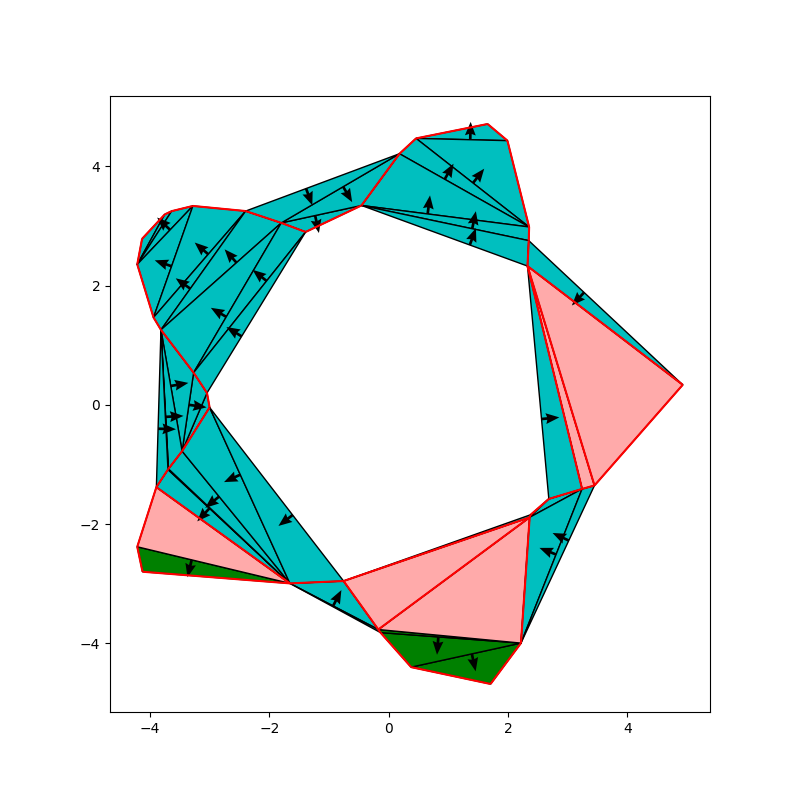

In [17]:
def arrow_coordinates(edge, face):
    v    = sum(points[np.array(face)])/3
    a    = points[edge[0]]
    b    = points[edge[1]]
    w    = a + np.dot(v-a, b-a)/la.norm(b-a)**2 * (b-a)
    d    = v-w
    if la.norm(d) > 0.05:
        d   *= max(la.norm(d), 0.3)/la.norm(d)
        return np.hstack((w, d))
    else:
        return None

arrows = [
    (arrow_coordinates(edge, face), radii[edge])
    for edge, face in paired_cofaces.items()
    if arrow_coordinates(edge, face) is not None
]

fig = plt.figure(figsize=(8, 8))
ax  = fig.gca()   
ax.set_aspect('equal')
ax.set_xlim(-R-r,R+r)
ax.set_ylim(-R-r,R+r)

def delaunay2d(thres=5):
    Del_r = \
        [
            triangle
            for triangle, radius in simplex_radii
            if len(triangle)==3 and radius <= thres
        ]
    Crit_r_1 = [
        edge
        for edge, radius in simplex_radii
        if len(edge)==2 and radius <= thres
        and edge in critical_edges
    ]
    Crit_r = set(Del_r) & set(critical_triangles)
    Wrap_r = set().union(*map(downset, Crit_r))

    ax.cla()
    ax.tripcolor(
        *points.T,
        Del_r, 
        [2 if t in Crit_r else 1 if t in Wrap_r else 0 for t in Del_r], 
        vmin=0, vmax=2, cmap=cmap, linewidth=1.0, edgecolor='k'
    )
    ax.add_collection(LineCollection(points[Crit_r_1], color='r'))
    
    arrows_r = np.array([
        arrow
        for arrow, radius in arrows 
        if radius < thres
    ])
    ax.quiver(*arrows_r.T, angles='xy', scale_units='xy', scale=1, width=0.0045, headwidth=4)
    
interact(delaunay2d, thres=(r_min, 10, 0.05));


### <a id="wrap3d" href="#top">👆</a> Wrap complex in 3D 
As a sample, we create points from a concave surface. We want to see how the Wrap complex respects the concave parts, which the Delaunay complex clearly does not.

In [18]:
import numpy as np
import numpy.linalg as la

R = 2.
r = 0.2
N = 35

# Surface of revolution with two concavities
# points  =   np.random.randn(3, N)
# points *= R/np.linalg.norm(points, axis=0)
# points[2] *= r + (1-r)*la.norm(points[0:2], axis=0)
# points = points.T

# Another surface of revoluion with a less uniform sampling.
#points = np.array([
#    (R*sin(t)**2 + r)*np.array([sin(t)*sin(s), sin(t)*cos(s), cos(t)])
#    for s, t in 2*pi*np.random.random_sample((N, 2))
#])

#points = np.array([
#    [0.1,0,0],
#    [0,0,-1],
#    [-1,.2,1.5],
#    [1,.2,1.5],
#    [0,-1,1],
#    [0,1,1]
#])

# Parabola
r = 0.5
points = np.random.randn(2, N)
points = np.vstack((points, r*la.norm(points, axis=0)**2)).T

In [ ]:
import mayavi.mlab as mlab
from IPython.display import display
from ipywidgets import interact
mlab.init_notebook('ipy')

fig = mlab.figure(size = (480,320), bgcolor = (1,1,1), fgcolor = (0, 0, 0))
@interact(z=(0,10,0.5))
def show(z):
    mlab.clf()
    points_below = points[points[:,2] <= z]
    mlab.points3d(*points_below.T, scale_factor=0.1, color=(0,.7,.7))
    display(fig)

We compute the convex hull of the point cloud, using NumPy, and the $alpha$-complex using Gudhi.

In [ ]:
import gudhi as gd
import operator as op
from scipy.spatial import ConvexHull, Delaunay

convex_hull = [tuple(sorted(simplex)) for simplex in ConvexHull(points).simplices if len(simplex==3)]
alpha_complex = gd.AlphaComplex(points=points)
st_alpha = alpha_complex.create_simplex_tree()

simplex_radii = [
    (tuple(simplex), radius)
    for simplex, radius in st_alpha.get_filtration()
]
radii = {
    simplex : radius for simplex, radius in simplex_radii    
}
simplices = list(map(op.itemgetter(0), simplex_radii))

assert(set(convex_hull) <= set(simplices))

In [ ]:
fig   = mlab.figure(size = (480,320), bgcolor = (1,1,1), fgcolor = (0, 0, 0))
cyan  = (0,.8,.8)
black = (0,0,0)
red   = (1,0,0)
yellow= (1,1,0)
def delaunay(thres=5):
    mlab.clf()
    filtration = [
        simplex for simplex, radius in simplex_radii if len(simplex)==3 and radius <= thres
    ]
    hull     = list(set(filtration) & set(convex_hull))
    not_hull = list(set(filtration) - set(convex_hull))
    mlab.triangular_mesh(*points.T, not_hull,   color=cyan)
    mlab.triangular_mesh(*points.T, hull,       color=red,   opacity=0.3)
    mlab.triangular_mesh(*points.T, filtration, color=black, representation='wireframe')
    display(fig)


interact(delaunay, thres=(0, 25, 0.05), continuous_update=False);

#### Intervals
$V$ now may also contain (edge, tetrahedron)-intervals, unlike in 2D, where only (edge, triangle)-intervals were possible, apart from singletons.  However, the $I\in V$ still are intervals, i. e., they  have unique maximal and minimal elements.

We consider simplices in order of decreasing $s_{\Del}$-value and dimension.
Thus, for each $I\in V$, we encounter its maximal element $\tau$ as first element of $I$ interval, and all other $\tau\in I$ are faces of $\sigma$.

In [ ]:
import itertools as it

intervals = []              # Will hold the collection of intervals.
covered   = set()           # Will hold the elements already contained in some interval.
critical  = []              # Will hold the critical elements.
intervals_of_simplices = {} # Will hold to every simplex the interval it is contained in.

# Lists all faces of dimension at least 1 of a simplex.
faces = lambda simplex: \
    it.chain(*[it.combinations(simplex, i) for i in range(1, len(simplex)+1)])

for simplex, simplex_radius in reversed(simplex_radii):
    if simplex not in covered:
        I = [
            face 
            for face in faces(simplex)
            if radii[face] == simplex_radius
        ]
        covered |= set(I)
        intervals_of_simplices.update({s : I for s in I}) 
        intervals.append(I)
        if len(I) == 1:
            critical.append(I[0])

Indeed, the $I$'s partition the complex:

 - $\bigcup_{I\in V} I = \Del$
 - for all $I\neq J: I\cap J=\emptyset$

And they are intervals indeed: every $I$ contains

 - its maximal element: $\bigcup I \in I$,
 - its minimal element: $\bigcup I \in I$
 - and all elements between: $\{\sigma\mid\bigcap I\leq\sigma\leq\bigcup I\}\subseteq I$.

In [ ]:
# The intervals form a partition:
assert(set().union(*intervals) == set(simplices))
assert(all(
    len(set(I) & set(J)) == 0 
    for I in intervals for J in intervals 
    if I != J
))

# And they are intervals:
top    = lambda I: tuple(sorted(set.union       (*map(set, I))))
bottom = lambda I: tuple(sorted(set.intersection(*map(set, I))))
assert(all([
    top(I)        in I 
    and bottom(I) in I
    and all(
        tuple(t)  in I
        for t in faces(top(I))
        if set(bottom(I)) <= set(t)
    )
    for I in intervals
]))

For each interval $I$, we compute the downset $\downset I$ as before. Since any $\sigma\in I$ is a face of the maximal element $\bigcup I$ of $I$, it suffices to compute $\downset I = \bigcup\{\downset J_\sigma\mid\sigma\subseteq\bigcup I\}$, where $J_\sigma$ is the unique interval containing $\sigma$.

In [ ]:
downsets = {}
def downset(s):
    s = top(intervals_of_simplices[s])
    if s not in downsets.keys():
        downsets[s] = set(intervals_of_simplices[s]).union(*[
            downset(top(intervals_of_simplices[t]))
            for t in faces(s) 
            if top(intervals_of_simplices[t]) != s
        ])
    return downsets[s]

for s in critical:
    downset(s)

Indeed, there are quite some four-elementary intervals:

In [ ]:
print(
    "Simplices below critical ones:",
    len(set.union(*map(downset, critical))),
    "\nTriangles not below any critical one:",
    len(set(simplices) - set.union(*map(downset, critical))),
    "\nCritical simplices:",
    len(critical),
    "\nNumber of n-elementary intervals:",
    *["n=%i: %i;" % (n, sum(1 for I in intervals if len(I)==n)) for n in [2,4]]
)


We see how the simplices not lying below any critical simplex (i. e., simplices from $\Del_r(X)\setminus\operatorname{Wrap}_r(X)$) fill the two cavities of the shape:

In [ ]:
from IPython.display import clear_output
@interact(thres=(0, 20, 0.05))
def delaunay(thres=8):
    fig = mlab.figure(size = (480,320), bgcolor = (1,1,1), fgcolor = (0, 0, 0))
    mlab.clf()
    Del_r = [
        simplex for simplex, radius in simplex_radii if len(simplex) == 3 and radius <= thres
    ]
    Crit_r = [
        simplex for simplex in Del_r if simplex in critical
    ]
    Wrap_r = [s for s in set().union(*[downset(s) for s in Crit_r]) if len(s)==3]
    mlab.triangular_mesh(*points.T, Del_r,   figure=fig, color=(0,0,.8), representation='wireframe')
    mlab.triangular_mesh(*points.T, list(set(Del_r)-set(Wrap_r)),   figure=fig, color=(0,0,.8), opacity=0.2)
    mlab.triangular_mesh(*points.T, list(set(Wrap_r)-set(Crit_r)),   figure=fig, color=(.8,.8,0))
    mlab.triangular_mesh(*points.T, Crit_r,   figure=fig, color=(0.8,0,0))
    display(fig)

#### The Discrete Vector Field of $s_{\Del}$

Again, we want to visualise the discrete vector field. We thus compute the coordinates and directions of the arrows representing that vector field.

In [ ]:
import numpy.linalg as la

def arrow_coordinates(face, coface):
    v = sum(points[np.array(coface)])/len(coface)
    a = points[face[0]]
    if len(face)==3:
        n  = np.cross(points[face[1]]-a, points[face[2]]-a)
        n /= la.norm(n)
        # Choose the foot of the perpendicular from v to face as origin of the arrow.
        # This will cause problems with skew tetrahedra, b/c w needn't lie in face.
        # w  = v - np.dot(v-a, n)*n
        # 
        # Just take the center of the face as origin of the arrow.
        w = sum(points[np.array(face)])/len(face)
    if len(face)==2:
        b  = points[face[1]]
        w  = a + np.dot(v-a, b-a)/la.norm(b-a)**2 * (b-a)
    if len(face)==1:
        w  = face[0]
    d  = v - w
    return np.hstack((w, d))

arrows = np.array([
    np.hstack((arrow_coordinates(face, top(intervals_of_simplices[face])), len(face), len(top(intervals_of_simplices[face])), radius))
    for face, radius in simplex_radii
    if face != top(intervals_of_simplices[face])
    #and len(face) == 3
    and arrow_coordinates(face, top(intervals_of_simplices[face])) is not None
])


In [ ]:
fig = mlab.figure(size = (480,620), bgcolor = (1,1,1), fgcolor = (0, 0, 0))
@interact(thres=(0, 30, 0.05))
def delaunay(thres=6):
    mlab.clf()
    
    # Select triangles and edges in the Delaunay- and the Wrap complex.
    Del_r    = [s for s, r in simplex_radii if len(s) == 3 and r <= thres]
    Crit_r   = [s for s in Del_r if s in critical]
    Del_r_1  = [s for s, r in simplex_radii if len(s) == 2 and r <= thres]
    Crit_r_1 = [s for s in Del_r_1 if s in critical]
    Wrap_r   = [s for s in set.union(*[downset(s) for s in Crit_r]) if len(s)==3]
    
    arrows_r = arrows[arrows[:,-1] <= thres]
    
    K = np.array([
        np.hstack((sum(points[np.array(s)])/len(s), len(s)))
        for s in critical
        if radii[s] <= thres
    ])
    S = np.vstack((arrows_r[:, :3], arrows_r[:, :3] + arrows_r[:,3:6]))#, K[:,:3]))
    C = np.hstack((arrows_r[:, 6], arrows_r[:,7]))#, K[:, 3]))

    mlab.triangular_mesh(*points.T, Del_r,                         color=black, representation='wireframe')
    mlab.triangular_mesh(*points.T, list(set(Del_r)-set(Wrap_r)),  color=(0,0,.8),  opacity=.3)
    mlab.triangular_mesh(*points.T, list(set(Wrap_r)-set(Crit_r)), color=yellow)
    mlab.triangular_mesh(*points.T, Crit_r,   figure=fig, color=red, opacity=1)
    
    # Display the arrows
    q = mlab.quiver3d(*arrows_r.T[:6], scalars=arrows_r.T[6], vmin=1, vmax=4, line_width=3, scale_factor=1, mode='arrow', scale_mode='vector', colormap='Accent')
    q.glyph.color_mode = 'color_by_scalar'
    
    # Display points at the tails and tips of the arrows.
    pts = mlab.points3d(*np.vstack((points, S)).T, np.hstack((1+np.zeros(len(points)), C)), colormap='Accent', vmin=4, vmax=4, scale_factor=0.04, scale_mode='none')

    # Draw the critical edges
    #pts = mlab.points3d(*points.T, scale_factor=0, color=(0,1,0))
    connections = np.array(Crit_r_1)
    pts.mlab_source.dataset.lines = connections
    tubes = mlab.pipeline.tube(pts, tube_radius=.015)
    mlab.pipeline.surface(tubes, color=(1,0,0))
    
    display(fig)
    
mlab.show_pipeline()


In [ ]:
import numpy as np
from mayavi import mlab

from traits.api import HasTraits, Range, Instance,on_trait_change
from traitsui.api import View, Item, Group
from mayavi.core.ui.api import MayaviScene, SceneEditor, MlabSceneModel

x, y = np.mgrid[0:3:1,0:3:1]

class MyModel(HasTraits):
    slider    = Range(-5., 5., 0.5, )    
    scene = Instance(MlabSceneModel, ())

    def __init__(self):
        HasTraits.__init__(self)
        self.s = mlab.surf(x, y, np.asarray(x*1.5, 'd'), figure=self.scene.mayavi_scene)

    @on_trait_change('slider')
    def slider_changed(self):
        self.s.mlab_source.scalars = np.asarray(x * (self.slider + 1), 'd')

    view = View(Item('scene', editor=SceneEditor(scene_class=MayaviScene)),
                Group("slider"))

my_model = MyModel()
my_model.configure_traits()